## <font color = "green"> Exposing <font color = "red">Fake Bills</font>: A Deep Dive into Counterfeit Currency Detection</font>

Currency remains a cornerstone of every economy, and despite the global shift towards a cashless society, the ability to authenticate physical banknotes remains indispensable. This validation serves not only financial institutions, large industries, and retailers but also empowers individuals to protect themselves from scams. Counterfeit money poses multifaceted challenges to society and the economy, including the devaluation of genuine currency, inflation, and the perpetuation of black money and corruption [(Yadav et al., 2020)](https://doi.org/10.1109/ICICCS51141.2021.9432274). In [Padmaja et al.'s article (2021)](https://doi.org/10.1088/1742-6596/2089/1/012008), it is difficult to identify fake banknotes for senior people and visually impaired people in India. This issue would be applied to all people who are senior and blind around the world.

**In response to these challenges, our project employs data analysis using classifications on a comprehensive dataset comprising 1,500 bills. The primary objective is to develop a robust system capable of accurately distinguishing between genuine and counterfeit money. This endeavor not only strengthens fraud prevention measures but also enhances financial security, contributing to the overall reliability of our monetary systems.**

Previous studies employed traditional strategies and simple machine learning algorithms for fake note detection. However, challenges arose with large datasets, leading to distortions and reduced precision. Recent advancements in the field have introduced efficient machine learning algorithms, deep convolutional neural networks, and image processing techniques, showcasing unprecedented efficacy in identifying fake currency [(Bhatia et al., 2021)](https://doi.org/10.1007/978-981-15-7106-0_17). As we delve into this project, we align ourselves with some innovative approaches to create a solution that addresses the evolving challenges posed by counterfeit money.

### Dataset Details

We will be working with a dataset that consists of 1500 rows and 7 columns, with each row representing an individual bill. The dataset comprises the following attributes:

- **is_genuine** (boolean): This column indicates whether the bill is genuine (True) or counterfeit (False).

- **diagonal** (float): Represents the diagonal measurements of the bill in millimeters.

- **height_left** (float): Denotes the height of the left side of the bill in millimeters.

- **height_right** (float): Indicates the height of the right side of the bill in millimeters.

- **margin_low** (float): Specifies the lower margin of the bill in millimeters.

- **margin_upper** (float): Defines the upper margin of the bill in millimeters.

- **length** (float): Represents the total length of the bill in millimeters.

These attributes form the basis of our analysis, as we delve into the exploration and prediction of bill authenticity within the dataset.


## <font color = "blue"> Preliminary Exploratory Data Analysis</font>

In [1]:
# load libraries here
install.packages("kknn")
library(repr)
library(tidyverse)
library(tidymodels)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks strin

### Reading in the Dataset
For this project, we will be using the [Fake Bills Dataset](https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills) from Kaggle.

In [2]:
bills_data <- read_delim("https://raw.githubusercontent.com/gordnzhou/DSCI-100-project/main/fake_bills.csv", 
                         delim = ";", show_col_types = FALSE )

head(bills_data)

is_genuine diagonal height_left height_right margin_low margin_up length
1 TRUE       171.81   104.86      104.95       4.52       2.89      112.83
2 TRUE       171.46   103.36      103.66       3.77       2.99      113.09
3 TRUE       172.69   104.48      103.50       4.40       2.94      113.16
4 TRUE       171.36   103.91      103.94       3.62       3.01      113.51
5 TRUE       171.73   104.28      103.46       4.04       3.48      112.54
6 TRUE       172.17   103.74      104.08       4.42       2.95      112.81

### Data Wrangling

Next, we'll format the data to meet our analysis needs. Luckily, the dataset is already tidy with well-formatted variable names, so there's no need for the `clean_names()` function from the `janitor` library. However, we'll still make essential adjustments for our analysis.

In [3]:
bills_data <- bills_data |>
    mutate(is_genuine = as_factor(is_genuine)) |>
    mutate(is_genuine = fct_recode(is_genuine, "Real" = "TRUE", "Fake" = "FALSE")) |>
    drop_na()
    
head(bills_data)

is_genuine diagonal height_left height_right margin_low margin_up length
1 Real       171.81   104.86      104.95       4.52       2.89      112.83
2 Real       171.46   103.36      103.66       3.77       2.99      113.09
3 Real       172.69   104.48      103.50       4.40       2.94      113.16
4 Real       171.36   103.91      103.94       3.62       3.01      113.51
5 Real       171.73   104.28      103.46       4.04       3.48      112.54
6 Real       172.17   103.74      104.08       4.42       2.95      112.81

### Summary and Visualization of Training Data

Now that our data is well-organized and in a tidy format, let's generate subsets and divide it into training and testing datasets.

- **Training Data:** This subset is foundational for training predictive models to distinguish genuine from counterfeit bills based on provided attributes. Analyzing this data helps uncover patterns for accurate predictions.

- **Testing Data:** The testing data subset is vital for evaluating the reliability and performance of our predictive models. Once the system is trained on the training data, it's essential to assess its performance on unseen data to validate its generalization and accuracy.

In [4]:
set.seed(99) # for reproducibility

bills_split <- initial_split(bills_data, prop = 0.75, strata = is_genuine)

bills_train <- training(bills_split)
bills_test <- testing(bills_split)

After setting up our training and testing datasets, we'll perform **exploratory data analysis** on the training data. This involves **creating statistical summaries and visualizations** to unveil insights into patterns and relationships among bill attributes. This analysis forms the basis for developing and improving our predictive model, aiming for precise differentiation between genuine and counterfeit bills.

In the following analysis, we highlight 3 key data features.
- The mean value for each explanatory variable.
- Out of 1125 training data rows, 375 are `Fake`, and 750 are `Real`, indicating roughly double the data for real bills than fake bills.
- A summary of descriptive statistics (mean and standard deviation) for each variable, stratified by the 'is_genuine' category.

In [15]:
bills_means <- bills_train |>
    select(diagonal:length) |>
    map_df(mean)

bills_count <- bills_train |>
    group_by(is_genuine) |>
    summarize(count = n())

bills_summary <- bills_train |>
    pivot_longer(cols = diagonal:length,
                 names_to = "column",
                 values_to = "value") |>
    group_by(column, is_genuine) |>
    summarize(mean = mean(value),
              sd = sd(value))   
        
bills_means
bills_count
bills_summary

`summarise()` has grouped output by 'column'. You can override using the
`.groups` argument.


diagonal height_left height_right margin_low margin_up length  
1 171.9582 104.0336    103.9237     4.488523   3.146545  112.6754

is_genuine count
1 Fake       369  
2 Real       728

column       is_genuine mean       sd       
1  diagonal     Fake       171.885772 0.3010119
2  diagonal     Real       171.994986 0.3058899
3  height_left  Fake       104.187561 0.2218500
4  height_left  Real       103.955536 0.2951049
5  height_right Fake       104.143144 0.2741229
6  height_right Real       103.812541 0.2848625
7  length       Fake       111.633496 0.6211166
8  length       Real       113.203489 0.3497890
9  margin_low   Fake         5.212114 0.5605523
10 margin_low   Real         4.121758 0.3209485
11 margin_up    Fake         3.338022 0.1779904
12 margin_up    Real         3.049492 0.1848971

We plotted our data **using bill length (`length`) on x-axis and upper margin (`margin_low`) on y-axis, with points color-coded by authenticity (Fig 1.)**.

A cluster of fake bills appears in the upper-middle-left, while real bills cluster in the lower-right, indicating shorter bill length and larger upper margin as indicative of fake bills.

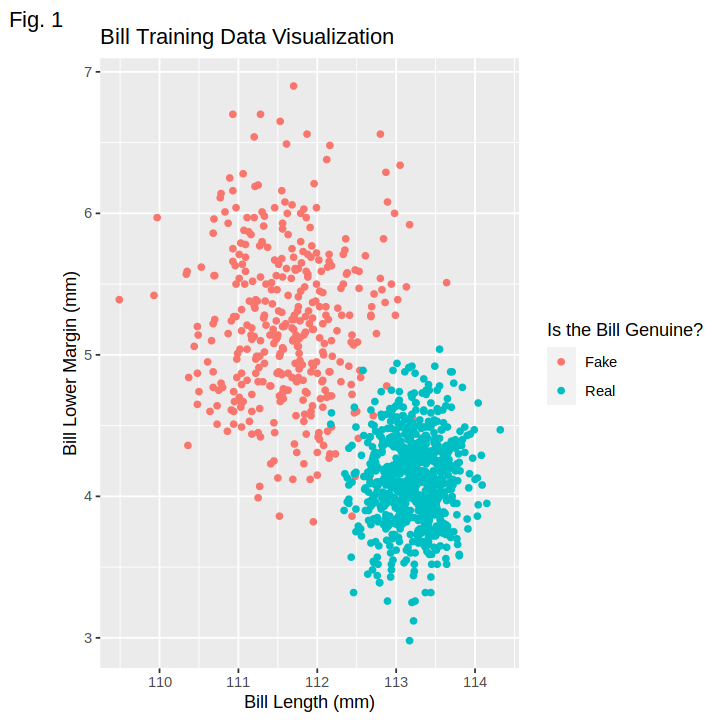

In [16]:
options(repr.plot.width = 6, repr.plot.height = 6)

bills_train_plot <- bills_train |>
    ggplot(aes(x = length, y = margin_low, colour = is_genuine)) +
        ggtitle("Bill Training Data Visualization") +
        geom_point() +
        labs(x = "Bill Length (mm)",
             y = "Bill Lower Margin (mm)",
             colour = "Is the Bill Genuine?",
             tag = "Fig. 1")

bills_train_plot

## <font color = "blue"> Methods</font>

For our explanatory variables, we will use `margin_low`, `margin_up`, and `length`. Let's plot the distributions of real and fake bills for **each of our usable variables** and compare. 

We can see in Fig 2. that the measurements for fake and real bills have comparatively less **overlap** in our chosen variables (`margin_low`, `margin_up`, and `length`), compared to the other three (`diagonal`, `height_left`, and `height_right`). This indicates that the variables that we chose have a stronger relationship with bill authenticity than others.

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


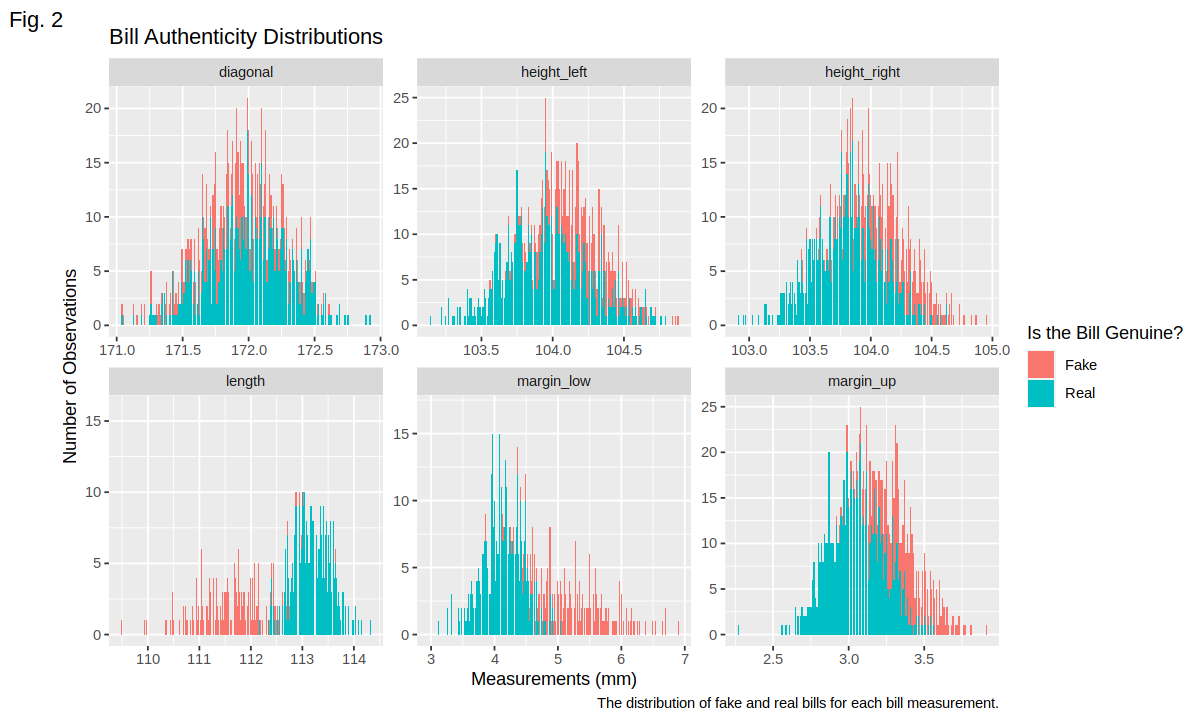

In [7]:
options(repr.plot.width = 10, repr.plot.height = 6)

# to separate variables for each distribution
bills_train_long <- bills_train |>
    pivot_longer(diagonal:length, names_to = "column")

bills_hist <- ggplot(bills_train_long, aes(x = value, fill = is_genuine)) +
    geom_histogram(stat = "count") +
    ggtitle("Bill Authenticity Distributions") +
    facet_wrap(column ~ ., scales = "free") +
    labs(x = "Measurements (mm)",
         y = "Number of Observations",
         fill = "Is the Bill Genuine?",
         tag = "Fig. 2",
         caption = "The distribution of fake and real bills for each bill measurement.")

bills_hist

In our analysis, we will use the **K-Nearest Neighbors Classification** algorithm for bill authenticity. **To find the best K, we will visualize Accuracy vs. K**. After model completion, we will plot predictor variables and prediction areas to validate our results.

### <font color = "blue">Determining Best K</font>

We will use **5-fold cross validation** to determine the best K value for our model, trying values from 1 to 5. Additionally, after a thorough examination of the summary tables depicting the spread of predictor variables, we observed a relatively similar distribution across the features. Consequently, we have made an informed decision not to scale our training data. *Scaling is a preprocessing technique that transforms numerical variables to a standard scale, and it is particularly useful when the spread of variables varies significantly.* However, **in our specific context, where the predictor variables exhibit comparable spreads, scaling is deemed unnecessary.**

neighbors mean     
1 1         0.9908841
2 2         0.9908841
3 3         0.9918015
4 4         0.9918015
5 5         0.9908883

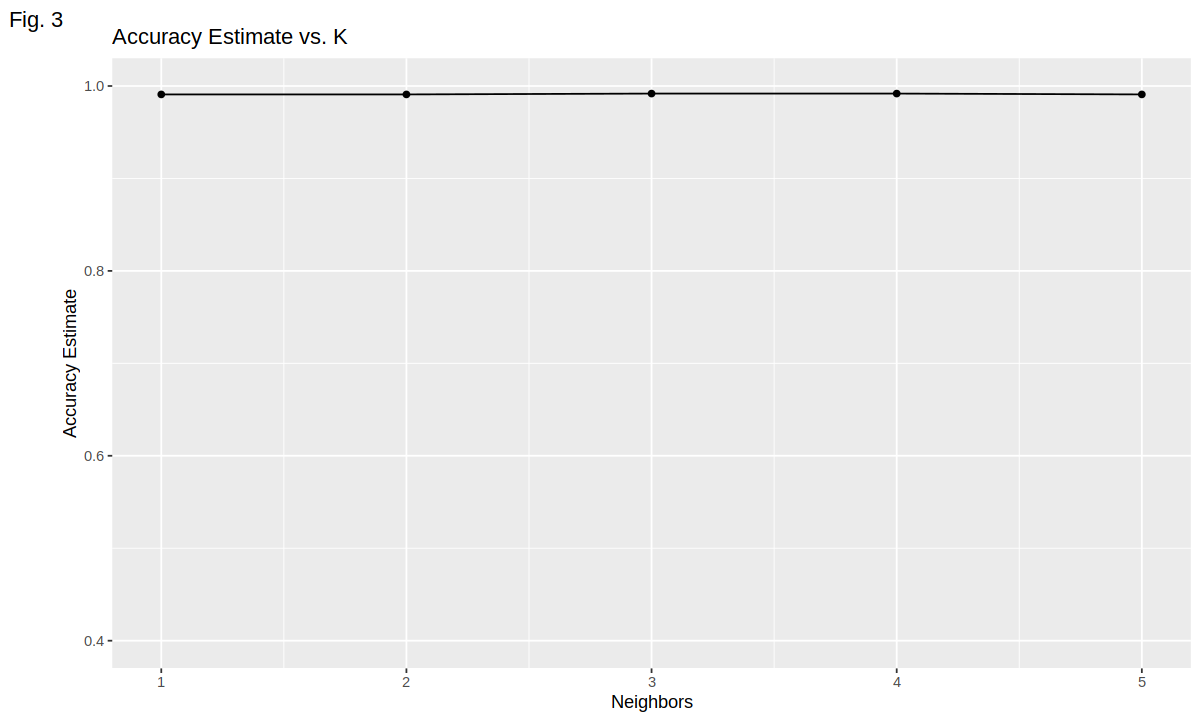

In [8]:
set.seed(727)

k_vals <- tibble(neighbors = c(1, 2, 3, 4, 5))

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_recipe <- recipe(is_genuine ~ margin_low + margin_up + length, 
                     data = bills_train)

train_vfold <- vfold_cv(bills_train, v = 5, strata = is_genuine)

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = train_vfold, grid = k_vals) |>
    collect_metrics(truth = is_genuine, estimate = .pred_class)

accuracies <- knn_fit |> 
      filter(.metric == "accuracy") |>
      select(neighbors, mean)

accuracies

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      ggtitle("Accuracy Estimate vs. K") +
      labs(x = "Neighbors", 
           y = "Accuracy Estimate",
           tag = "Fig. 3",) +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

cross_val_plot

Looking at Fig. 3, we can see that our model maintains a very high accuracy among all K values. The reason this could be happening is because our predictor variables' data have low variance. The limited variability in the predictor variables contributes to the model's robust performance, as the predictive features exhibit a stable and consistent influence on the outcomes. **The high accuracy maintained across different K values underscores the reliability of our model, which remains effective in capturing patterns and making accurate predictions despite the low variance in the input data.**

In [10]:
best_k = 4

### <font color = "blue">Training and Evaluating our Model</font>

We will use **K = 4** in this research for analyzing training data and testing data.

In [11]:
set.seed(1111)

bills_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

bills_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(bills_spec) |>
    fit(data = bills_train)

bills_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(4,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.01002735
Best kernel: rectangular
Best k: 4

In [12]:
bills_predictions <- predict(bills_fit, bills_test) |>
    bind_cols(bills_test)

bills_metrics <- bills_predictions |>
  metrics(truth = is_genuine, estimate = .pred_class)

bills_conf_mat <-  bills_predictions |>
    conf_mat(truth = is_genuine, estimate = .pred_class)

bills_metrics
bills_conf_mat

.metric  .estimator .estimate
1 accuracy binary     0.9890710
2 kap      binary     0.9755094

          Truth
Prediction Fake Real
      Fake  121    2
      Real    2  241

As it turns out, our model has a **98.9% accuracy!** Based on the confusion matrix, it also has both **a precision and recall of 99.2%**. 

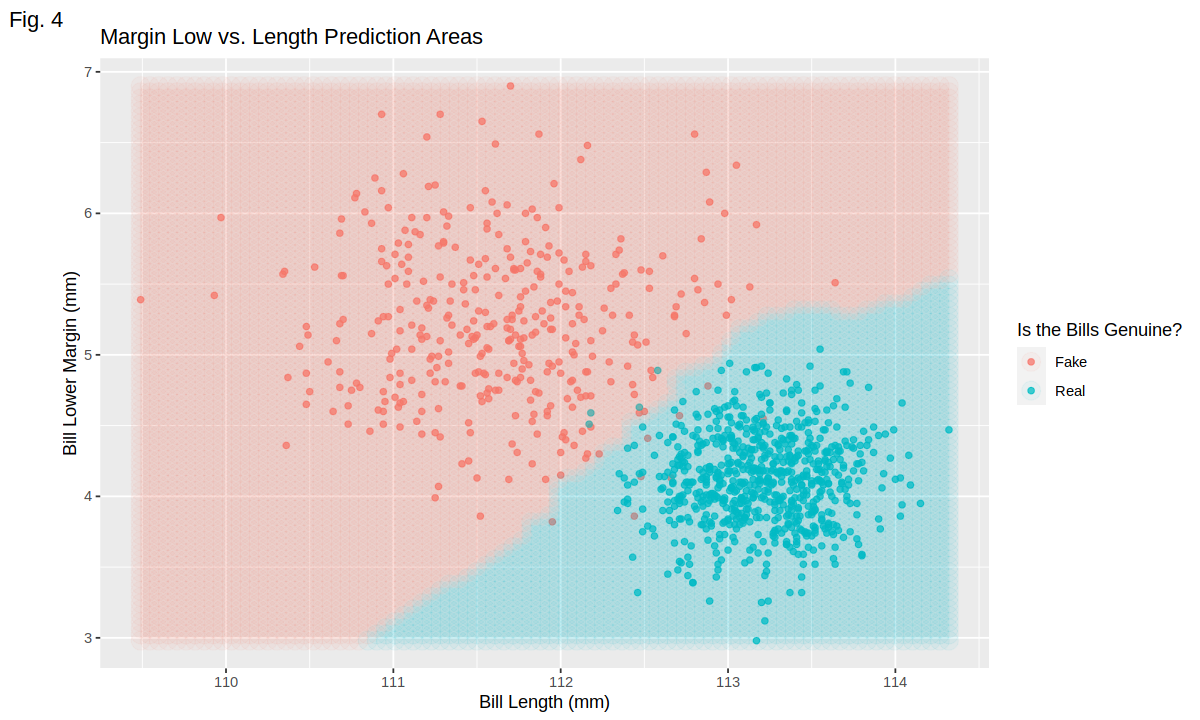

In [28]:
l_grid <- seq(min(bills_train$length),
                max(bills_train$length),
                length.out = 90)
ml_grid <- seq(min(bills_train$margin_low),
                  max(bills_train$margin_low),
                  length.out = 90)
mean_mu <- bills_train |>
    summarize(bmean = mean(margin_up)) |>
    pull()

# ONLY BASED OFF LENGTH AND MARGIN LOW
scgrid <- as_tibble(expand.grid(length = l_grid,
                                margin_low = ml_grid,
                                margin_up = mean_mu)) 

knnPredGrid <- predict(bills_fit, scgrid)
prediction_table <- bind_cols(knnPredGrid, scgrid) |>
    rename(is_genuine = .pred_class)

options(repr.plot.width = 10, repr.plot.height = 6)

predictions_plot <- ggplot() +
    geom_point(data = bills_train,
               mapping = aes(x = length,
                             y = margin_low,
                             color = is_genuine),
               alpha = 0.75) +
    geom_point(data = prediction_table,
               mapping = aes(x = length,
                             y = margin_low,
                             color = is_genuine),
               alpha = 0.05,
               size = 5.) +
    labs(color = "Is the Bills Genuine?",
         x = "Bill Length (mm)",
         y = "Bill Lower Margin (mm)",
         tag = "Fig. 4") +
    ggtitle("Margin Low vs. Length Prediction Areas")

predictions_plot

We plotted our predictions (Fig. 4) and we can see that there does not appear to be any significant overfitting or underfitting. The color of the points indicates whether the bill is predicted to be genuine or counterfeit. This visualization provides valuable insight into how the model distinguishes between the two classes based on specified features, offering a comprehensive view of the prediction areas in the feature space.

### <font color = "blue"> Summary of Findings: </font>

- **Algorithm Selection:**
The K-Nearest Neighbors Classification algorithm was deliberately chosen for its simplicity and effectiveness in handling binary classification tasks.

- **Optimal K-Value Determination:** A systematic approach was undertaken to determine the optimal k-value through a grid search. The visualization depicting accuracy vs. k facilitated the informed selection of k=4 as the most suitable parameter.

- **Model Accuracy and Stability:** The final model, trained with k=4, demonstrated exceptional accuracy, reaching approximately 99%. This level of accuracy suggests a robust relationship between the selected features (margin_low, margin_up, length) and bill authenticity. Even with variations in the k-value, the accuracy remained consistently high, indicating the stability and reliability of the model.

- **Visualization of the Analysis:** The scatter plot not only served as a visual representation but also reinforced the effectiveness of the chosen features. The clear separation observed aligns with expectations and emphasizes the potential practical application of the model in distinguishing genuine and counterfeit currency.

- **Prediction and Confusion Matrix:** The model was applied to the testing subset, and predictions were compared with the actual labels. The confusion matrix revealed an accuracy of 98.91%, emphasizing the model's proficiency in correctly classifying bills. The small number of misclassifications underscores the reliability of the KNN model.

- **Visualizing Prediction Areas:**  Prediction areas, visualized based on bill length and lower margin, showcased the model's discriminative capabilities. Real bills predominantly occupied distinct areas from those of fake bills, validating the efficacy of the model.
    Feature Sensitivity:
    
- **Future Considerations for KNN Model:**
  - *Feature Sensitivity:* Investigate the sensitivity of the model to different feature sets. Exploring additional features or variations in feature selection may enhance the model's adaptability.
  - *Cross-Validation:* Extend model evaluation to diverse datasets to ensure generalizability. Assessing performance across various bill designs and currencies is essential for broader applicability.

### <font color = "blue"> Expected Outcomes and Significance</font>
- The observed patterns in the scatter plot were consistent with expectations, confirming that certain geometric attributes (specifically length and lower margin) strongly correlate with bill authenticity. The model's high accuracy further affirms the reliability of these features as indicators.
- The high accuracy achieved by the model holds profound significance in the realms of fraud prevention and economic security. By implementing such a dependable counterfeit detection system, the potential for safeguarding financial institutions and individuals is substantial. This, in turn, contributes to fostering trust in monetary systems, an integral element for the stability of any economy.

### <font color = "blue"> Future Questions</font>

**1. Application to Global Currencies:**
The success of this project prompts the exploration of how the principles and insights gained can be applied to authenticate other global currencies. Understanding the adaptability of the model to various currencies could have far-reaching implications for international fraud prevention and detection.

**2. Advanced Authentication Methods:**
This project sets the stage for the consideration of advanced authentication methods, potentially influencing the integration of sensor technology and machine learning in ATMs and cash handling systems. The combination of these technologies could elevate the security standards in currency-related transactions.

**Our project extends beyond the immediate achievement of counterfeit detection. It serves as a foundational step towards enhancing fraud prevention, fortifying financial security, and instilling trust in currency-related transactions. It paves the way for future investigations in currency authentication and opens avenues for innovation & the application of cutting-edge technologies in the domain of monetary systems.**

### <font color = "green"> References:</font>

- Bhatia, A., Kedia, V., Shroff, A., Kumar, M., Shah, B. K., &amp; Aryan. (2021). Fake currency detection with machine learning algorithm and Image Processing. *2021 5th International Conference on Intelligent Computing and Control Systems (ICICCS)*, 755-760. https://doi.org/10.1109/iciccs51141.2021.9432274 

- Padmaja, B., Naga Shyam Bhargav, P., Ganga Sagar, H., Diwakar Nayak, B., &amp; Bhushan Rao, M. (2021). Indian currency denomination recognition and fake currency identification. *Journal of Physics: Conference Series, 2089*(1), 15-16. https://doi.org/10.1088/1742-6596/2089/1/012008  

- Yadav, R. K., Valecha, P., & Paliwal, S. (2020). Counterfeit currency detection using supervised machine learning algorithms. *In Lecture notes in networks and systems, 141*, 173–178. https://doi.org/10.1007/978-981-15-7106-0_17

### <font color = "green"> Dataset Citation:</font>

- Alexandre Petit (2021) [Fake Bills Dataset](https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills) (Kaggle)
